## Word2Vec in keras. 
* based partially on: https://adventuresinmachinelearning.com/word2vec-keras-tutorial/

In [1]:
# We'll implement the skip-gram model first (CBOW later)

Note that to implement negative sampling, we'll follow the following procedure:
* Construct a binary output layer instead of multi-class
* Output is True if we are suppling the target word and a true context word
* Output is False if we are suppling the target word and a a negative sample (i.e. a word sampled which is NOT in the context of the target)
* To ensure that similar words end up having similar embeddings, we'll use cosine similarity. This should give a 1 when two words are in the same context and 0 otherwise
Broadly, the network will look like:
* An integer input (i.e. the index of the target word in the vocabulary) and a true or false context word
* An embedding layer lookup (i.e. looking up the embedding vector in the embedding matrix)
* The dot product operation (i.e. to compute the cosine similarity)
* The output layer: a sigmoid here.

In [192]:
# Import modules:
from __future__ import division

import os
import sys
import pandas as pd
import keras
import keras.backend as K
import numpy as np
import functools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from IPython.display import SVG
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.callbacks import History 
import urllib
import zipfile
import tensorflow as tf
import collections
sys.path.insert(0, '/Users/danielokeeffe/Documents/src/nlp_preprocessing/')
import nlp_preprocessing

In [572]:
# Reload nlp_preprocessing if you add any functions to it
reload(nlp_preprocessing)

<module 'nlp_preprocessing' from '/Users/danielokeeffe/Documents/src/nlp_preprocessing/nlp_preprocessing.py'>

In [311]:
class SimilarityCallback:
    def __init__(self, valid_size, dictionary, valid_examples, vocab_size, validation_model):
        self.valid_size = valid_size
        self.dictionary = dictionary
        self.valid_examples = valid_examples
        self.vocab_size = vocab_size
        self.validation_model = validation_model
        
    def run_sim(self):
        for i in range(self.valid_size):
            valid_word = self.dictionary[self.valid_examples[i]]
            # Define the number of nearest neighbours
            top_k = 8
            sim = self._get_sim(self.valid_examples[i])
            nearest = (-sim).argsort()[1:top_k+1]
            log_str = 'Nearest to {0}: '.format(valid_word)
            for k in range(top_k):
                close_word = self.dictionary[nearest[k]]
                log_str = '{0} {1},'.format(log_str, close_word)
            print(log_str)
            

    def _get_sim(self, valid_word_idx):
        sim = np.zeros((self.vocab_size,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        for i in range(self.vocab_size):
            in_arr1[0,] = valid_word_idx
            in_arr2[0,] = i
            out = self.validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim

In [288]:
def plot_model(model):
    return SVG(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [441]:
def predict_on_validation_model(word_list, dictionary, reversed_dictionary, validation_model, vocab_size, top_k=8):
    """A function to return the top_k most similar words after training of the primary model"""
    # Verify that the words in the input word list are actually in the dictionary
    try:
        print(word_list)
        word_indices = [reversed_dictionary[word] for word in word_list]
        print(word_indices)
    except KeyError:
        print('a supplied word is not in dictionary')
        return None
    for i in range(len(word_indices)):
        test_word = word_list[i]
        sim = validation_get_sim(valid_word_idx=word_indices[i], 
                                 validation_model=validation_model, 
                                 vocab_size=vocab_size)
        nearest = (-sim).argsort()[1:top_k+1]
        log_str = 'Nearest to {0}: '.format(test_word)
        for k in range(top_k):
            close_word = dictionary[nearest[k]]
            log_str = '{0} {1},'.format(log_str, close_word)
        print(log_str)

In [442]:
def validation_get_sim(valid_word_idx, validation_model, vocab_size):
    sim = np.zeros((vocab_size,))
    in_arr1 = np.zeros((1,))
    in_arr2 = np.zeros((1,))
    for i in range(vocab_size):
        in_arr1[0,] = valid_word_idx
        in_arr2[0,] = i
        # out = validation_model.predict_on_batch([in_arr1, in_arr2])
        out = validation_model.predict([in_arr1, in_arr2])
        sim[i] = out
    return sim

In [517]:
# Load data.  We'll use the text data at: 'http://mattmahoney.net/dc/' The filename is text8.zip
url = 'http://mattmahoney.net/dc/'
filename = download_file('text8.zip', url)

In [518]:
filename = nlp_preprocessing.download_file('text8.zip', url)

In [519]:
vocabulary = nlp_preprocessing.read_data_from_zip(filename=filename)

In [520]:
len(vocabulary)

1

In [524]:
len(vocabulary[0])

17005207

In [522]:
# This is pretty big, so we'll produce a trimmed version of the vocabulary of the n most common words, say 10,000
vocab_size = 10000

In [573]:
dictionary, reversed_dictionary = nlp_preprocessing.build_data_for_keras_skipgram(vocabulary=vocabulary[0], vocabulary_size=vocab_size)

In [574]:
len(dictionary)

10000

In [575]:
len(reversed_dictionary)

10000

In [576]:
reversed_dictionary['a']

6

In [577]:
dictionary[6]

'a'

In [578]:
dictionary[1000]

'fall'

In [579]:
reversed_dictionary['fall']

1000

In [580]:
dictionary[1]

'the'

In [581]:
dictionary[9999]

'panda'

In [582]:
reversed_dictionary['UNK']

0

In [583]:
# Before we delete the vocabulary, we need the sequence of words (i.e. vocabulary) translated into indices.  This is necessary for the skipgram selection below.
sequence_of_indices, unk_count = nlp_preprocessing.make_sequence_of_indices_from_vocabulary(vocabulary=vocabulary, reversed_dictionary=reversed_dictionary)

In [584]:
len(sequence_of_indices)

1

In [585]:
len(sequence_of_indices[0])

17005207

In [586]:
len(unk_count)

1

In [587]:
unk_count

[1737307]

In [588]:
# Which is 
1737307/17005207

0.10216323741310529

In [589]:
# About 10.2% unk...
sequence_of_indices[0][0:10]

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]

In [590]:
vocabulary[0][0:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [591]:
for idx in sequence_of_indices[0][0:10]:
    print(dictionary[idx])

anarchism
originated
as
a
term
of
abuse
first
used
against


In [499]:
# Ok great, so that should preserve the sequence information we'll need.

In [592]:
# So now we don't need the full vocabulary anymore.
del vocabulary

# Define some basic parameters

In [593]:
# the window of words around the target to will be used to draw context samples:
window_size = 3
# The size of each word embedding vector:
vector_dim = 300
# The number of epochs to train for. This is going to be big.  Even with negative sampling, creating a decent embedding matrix can take awhile
epochs = 100000

In [594]:
# We'll need to setup a validation set. This will be used to check to see what words grow in similarity as we train the network.
# We'll select a random set of words to measure similarity on
valid_size = 16
# We want to select these words from the top 100 most common words in the dataset.  We didn't explicitly create the dictionary this way...we'll do it at random for now...
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Implement skipgram

In [595]:
# The sampling table will make sure we sample both true and false context words in a balanced way and not just select the most common words
sampling_table = keras.preprocessing.sequence.make_sampling_table(vocab_size)
# We need to supply the sequence of indices or the text.  It's only one document, so we'll send just the zeroth element of sequence_of_indices 
couples, labels = keras.preprocessing.sequence.skipgrams(sequence_of_indices[0], vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype='int32')
word_context = np.array(word_context, dtype='int32')

In [596]:
print(couples[:10], labels[:10])

([[1303, 26], [2740, 31], [6266, 299], [8247, 7053], [2080, 3834], [4996, 4366], [641, 682], [507, 6498], [1307, 2732], [8302, 3009]], [1, 1, 0, 0, 0, 0, 1, 0, 1, 0])


In [597]:
# To actually implement the embedding layers, we'll need to use the functional API.  We need to share a single embedding layer between two tensors (target word and context 
# words), and an additional output to measure similarity.

In [598]:
# Create input variables, one for the target, one for the context. We're just going to supply the target word and a context word individually, so the size of the inputs are both 1.
input_target = keras.Input((1,))
input_context = keras.Input((1,))

In [599]:
# Create the embedding layer (we should try out different initializers for the weights also):
embedding = keras.layers.Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

In [600]:
# Now we need to be able to lookup target and context words in the embedding layer to measure similarity.
target = embedding(input_target)
target = keras.layers.Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = keras.layers.Reshape((vector_dim, 1))(context)

In [601]:
# Setup the similarity measurement
similarity = keras.layers.dot([target, context], normalize=True, axes=0)

In [602]:
dot_product = keras.layers.dot([target, context], normalize=False, axes=0)
dot_product = keras.layers.Reshape((1,))(dot_product)
output = keras.layers.Dense(1, activation='sigmoid')(dot_product)

In [603]:
# Compile the model
model = keras.Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [604]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       3000000     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
reshape_26 (Reshape)            (None, 300, 1)       0           embedding[0][0]                  
__________

In [605]:
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           1
          InputLayer     |   -------------------         0     0.0%
                       #####           1
          InputLayer     |   -------------------         0     0.0%
                       #####           1
           Embedding   emb | -------------------   3000000    99.0%
                       #####      1  300
             Reshape     |   -------------------         0     0.0%
                       #####    300    1
             Reshape     |   -------------------         0     0.0%
                       #####    300    1
                 Dot   ????? -------------------         0     0.0%
                       #####      1    1
             Reshape     |   -------------------         0     0.0%
                       #####           1
               Dense   XXXXX -------------------         2     0.0%
             sigmoid   #####           1


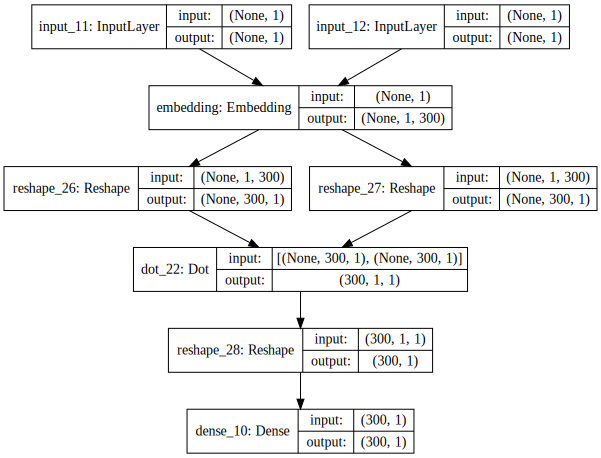

In [606]:
# A nicer visualization of the word2vec skipgram model used here.
plot_model(model)

In [607]:
# To get to the validation we want to track, we'll initialize a secondary model. This model should share the the embedding layer with the primary model.  We aren't actually going to
# train this model, so we don't need to compile it.
validation_model = keras.Model(inputs=[input_target, input_context], outputs=similarity)

In [608]:
# Setup the similarity callback objecct
sim_cb = SimilarityCallback(valid_size=valid_size, 
                            dictionary=dictionary, 
                            valid_examples=valid_examples, 
                            vocab_size=vocab_size, 
                            validation_model=validation_model)

In [609]:
# Now we can train this thing.
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)
    if cnt % 1000 == 0:
        print('Iteration {0}, loss = {1}'.format(cnt, loss))
    if cnt % 10000 == 0:
        sim_cb.run_sim()

Iteration 0, loss = 0.697695851326
Nearest to from:  delaware, favourite, luxembourg, db, calculate, shift, value, retain,
Nearest to no:  null, stuart, map, webster, traditional, blend, universally, know,
Nearest to so:  slavery, potentially, locomotives, tensions, louis, handful, contracted, study,
Nearest to of:  papers, fortran, shoes, physicists, prepared, names, balance, greek,
Nearest to however:  motor, absorbed, openly, gov, coach, algebraic, tcp, studies,
Nearest to at:  woman, rolls, prosecution, masculine, aged, amino, heroin, series,
Nearest to had:  officials, israelites, week, carlos, grande, possibility, variant, substance,
Nearest to use:  solids, dam, finally, comment, proud, correctly, delhi, hp,
Nearest to i:  successive, rangle, compatible, cameras, boeing, burke, sand, vessel,
Nearest to are:  centralized, herzegovina, upcoming, elevator, smoking, couples, recall, swiss,
Nearest to first:  tense, testament, ultra, denominations, calculation, emancipation, species,

In [610]:
predict_on_validation_model(word_list=['six', 'eight', 'one', 'two', 'nine', 'seven'], dictionary=dictionary, reversed_dictionary=reversed_dictionary, validation_model=validation_model, vocab_size=vocab_size)

['six', 'eight', 'one', 'two', 'nine', 'seven']
[22, 13, 4, 10, 9, 23]
Nearest to six:  three, eight, one, nine, four, five, zero, and,
Nearest to eight:  seven, nine, four, zero, three, one, two, six,
Nearest to one:  nine, four, five, three, eight, zero, six, seven,
Nearest to two:  four, nine, zero, eight, seven, three, one, and,
Nearest to nine:  eight, seven, four, one, two, zero, six, three,
Nearest to seven:  eight, four, nine, one, three, two, zero, five,


In [611]:
predict_on_validation_model(word_list=['acquire'], dictionary=dictionary, reversed_dictionary=reversed_dictionary, validation_model=validation_model, vocab_size=vocab_size)

['acquire']
[6791]
Nearest to acquire:  able, paint, synonym, dry, active, karaoke, oath, skull,


In [613]:
reversed_dictionary.items()[0:10]

[('writings', 1532),
 ('homomorphism', 9648),
 ('yellow', 2457),
 ('four', 21),
 ('prefix', 5771),
 ('jihad', 5607),
 ('hanging', 8021),
 ('cyprus', 3421),
 ('aggression', 7861),
 ('looking', 2399)]

In [614]:
predict_on_validation_model(word_list=['homomorphism', 'yellow', 'jihad'], dictionary=dictionary, reversed_dictionary=reversed_dictionary, validation_model=validation_model, vocab_size=vocab_size)

['homomorphism', 'yellow', 'jihad']
[9648, 2457, 5607]
Nearest to homomorphism:  relationship, july, homogeneous, piece, nineteenth, squares, necessity, attacked,
Nearest to yellow:  kingdom, interpretations, alchemy, functional, the, constituent, null, finish,
Nearest to jihad:  ray, on, death, international, conditional, further, following, at,


In [615]:
# Interesting.